<div align="center"><h1>Control Engineering Basics</h1>
<br><b>Dr.Varodom Toochinda</b>
<br>Dept. of Mechanical Engineering, Kasetsart University</div>

### Supplement to Module 4 : PID control

<a href="https://colab.research.google.com/github/dewdotninja/control_python/blob/master/autotuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<b>Requirement : </b> Python 3 with Python control systems library
<p />Execute the commands below to install Python control systems library in Colab    

In [ ]:
!pip install control

<h3>Automatic Tuning using Relay Feedback</h3>
<p />From the disadvantage of manual ZNFD tuning that requires a user to adjust the $K_p$ gain to the brink of instability, 
we would prefer to obtain plant output oscillation without destabilizing the system. A relay feedback helps us achieve just that.
<p />As shown in Figure 1, when a relay is put in place of a controller, it could cause the plant output to oscillate. This is true for a plant with its Nyquist plot crossing the negative real axis. If this is not the case, a relay with hysteresis may be used. Generally speaking, for a plant with order greater than 2, a simple relay can be applied. 
A relay is a nonlinear device. To analyze relay feedback as a linear system, a technique called describing function 
can be applied. See our online article, or [1] for detailed analysis. Here we only summarize the result. 
<div align="center">
<img src="https://raw.githubusercontent.com/dewdotninja/sharing-github/master/autotune-fig1.png" width=600 />
</div>

<div align="center"><b>Figure 1 feedback system with relay</b></div>
<p />For a non-hysteresis relay, its describing function is
$$
N(a) = \frac{4d}{\pi a}
$$
<div align="right">(14)</div>
<p />Where $d$ and $a$ are the relay amplitude and plant output magnitude of oscillation, respectively. At the 
oscillation point, the Nyquist curve must intersect the negative axis at $-1/N(a)$. It concludes that the ultimate 
gain $K_u$ equals $N(a)$. $T_u$ can then be measured as before. 
<p />
<b>Example 1: </b> Construct a relay feedback system shown in Figure 1, with a third order lag plant 
$$
P(s) = \frac{1}{(s+1)^3}
$$

In [2]:
import control as ctl 
import numpy as np
import matplotlib.pyplot as plt

Because a relay is a nonlinear device, we cannot form a closed-loop system as easily as the case of linear control.
Here a method to perform discrete-time simulation of the relay feedback system is used.

Discrete-time plant

1.231e-07 z^3 + 3.694e-07 z^2 + 3.694e-07 z + 1.231e-07
-------------------------------------------------------
           z^3 - 2.97 z^2 + 2.941 z - 0.9704

dt = 0.01



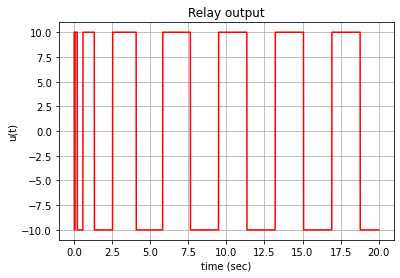

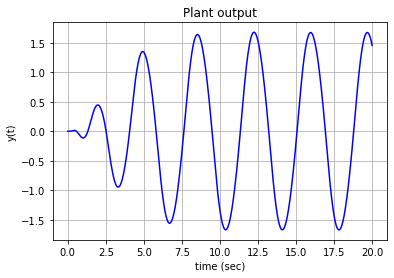

In [8]:
pnum = 1
lag1 = [1,1]   # (s+1)
pden = np.convolve(lag1, lag1)  # (s+1)^2
pden = np.convolve(pden, lag1)  # (S+1)^3
P = ctl.tf(pnum,pden)

Ts = 0.01
d = 10

Pd = ctl.sample_system(P, Ts, method='tustin')
print("Discrete-time plant")
print(Pd)
Pdnum, Pdden = ctl.tfdata(Pd)
pdnum = np.squeeze(np.array(Pdnum))
pdden = np.squeeze(np.array(Pdden))
tvec = np.arange(0,20,Ts)  # change time scale to suit
yvec = np.zeros(tvec.shape)
uvec = np.zeros(tvec.shape)
numorder = len(pdnum)  # 4 for this example
denorder = len(pdden)  # 4
y_prev = np.zeros((denorder,1)) 
u_prev = np.zeros((numorder,1))
i = 0
# perform discrete-time simulation 
for i in range(len(tvec)):
    for k in range(numorder-1):
        u_prev[k] = u_prev[k+1]
    for k in range(denorder-1):
        y_prev[k] = y_prev[k+1]
        
    if y_prev[denorder-1]>0:  # relay feedback
        uvec[i] = -d
    else:
        uvec[i] = d
    u_prev[numorder-1] = uvec[i]        
    yvec[i] = pdnum[0]*uvec[i]
    for k in range(denorder-1):
        yvec[i] = yvec[i]+pdnum[k+1]*u_prev[numorder-2-k] - pdden[k+1]*y_prev[denorder-2-k]
    y_prev[denorder-1] = yvec[i]
    
# plot the result
plt.figure()
plt.plot(tvec,uvec,'r-')
plt.grid('True')
plt.xlabel('time (sec)')
plt.ylabel('u(t)')
plt.title("Relay output")

plt.figure()
plt.plot(tvec, yvec,'b-')
plt.grid('True')
plt.xlabel('time (sec)')
plt.ylabel('y(t)')

plt.title("Plant output")

plt.show()


From the result, we can compute $K_u = N(a) = \frac{4d}{\pi a}$, where $d = 10$ and the oscillation magnitude $a$ is about 1.6. 
Hence,

In [4]:
Ku = 40/(np.pi*1.6)
Ku

7.957747154594767

$T_u$, the oscillation period, is roughly measured to about 3.7 seconds. Now we want to verify this by forming a PID feedback
with the same plant. Define a function as follows.

In [9]:
# PID controller function
def pid(Kp, Ki, Kd, P, tvec):
    cnum = [Kd, Kp, Ki] 
    cden = [0, 1, 0]
    C = ctl.tf(cnum,cden)
    r = np.ones(tvec.shape)
    L = C*P
    sys = ctl.feedback(L)
    #print(sys)
    T, y = ctl.step_response(sys, tvec)

    plt.figure()
    plt.plot(T,r,'b',T,y,'r-')
    plt.grid('True')
    plt.xlabel('time (sec)')
    plt.ylabel('output')
    
    plt.legend(['step ref.','y'])
    plt.show()

and then do the simulation with $K_p = K_u = 8$, and $K_i = K_d = 0$. 

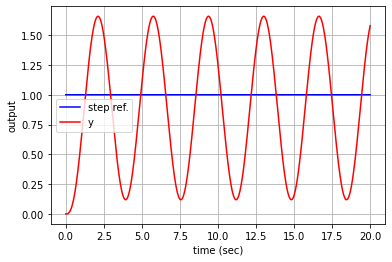

In [10]:
Kp = 8
Ki = 0
Kd = 0
tvec = np.arange(0,20,0.01)
pid(Kp, Ki, Kd, P, tvec)

The response does oscillate, with $T_u$ quite close to the oscillation from relay feedback; i.e., about 3.7 seconds. 
<p />We can see from this experiment how PID auto-tuning using relay feedback works. Using the adjusted values in Table 2 of 
module 4 yields the following response

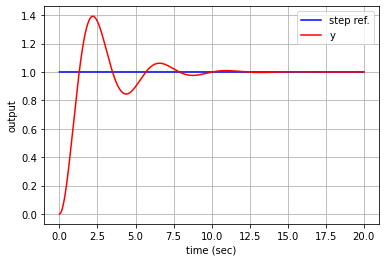

In [11]:
Ku = 8
Tu = 3.7
Kp = 0.6*Ku
Ki = 1.2*Ku/Tu
Kd = 0.075*Ku*Tu
tvec = np.arange(0,20,0.01)
pid(Kp, Ki, Kd, P, tvec)

As expected, the response from PID tuned by ZNFD method has significant overshoot.  

<h3>References</h3>
<ol>
<li>K.J. Astrom and T.Hagglund. PID Controllers, 2nd ed., Instrument Society of America, 1995.</li>
<li>M.W.Spong, S. Hutchinson and M. Vidyasagar,  Robot Modeling and Control. John Wiley & Sons. 2006. </li>
<li>V. Toochinda. Digital PID Controllers,  2009. </li>
<li>V.Toochinda. Robot Analysis and Control with Scilab and RTSX</a>. Mushin Dynamics, 2014. </li>
</ol>

<b>Last Updated : </b> March 11, 2024

Update list :
<ul>
<li />March 11, 2024 : Move all figures from google drive to github.
<li />October 25, 2022:
    <ul>
    <li />Remove <code>!pip install slycot</code>
    </ul>
</ul>

<p align="center">
<img src="https://drive.google.com/thumbnail?id=13bzT7Rmy3bzvE7TiS0yfQo94kpxMuipF" alt="dewninja"/>
</p>
<div align="center">dew.ninja<br>Copyright 2021</div>